In [1]:
import math

def calculate_zoom_level(bounds, image_width=1024, image_height=1024, tile_size=256):
    """
    適切なズームレベルを計算
    :param bounds: バウンディングボックス [minx, miny, maxx, maxy]
    :param image_width: 合成画像の幅 (px)
    :param image_height: 合成画像の高さ (px)
    :param tile_size: タイルサイズ (px)
    :return: 適切なズームレベル (int)
    """
    lon_diff = bounds[2] - bounds[0]
    lat_diff = bounds[3] - bounds[1]

    # 経度と緯度のタイル幅を計算
    lon_zoom = math.log2(360 / lon_diff * (image_width / tile_size))
    lat_zoom = math.log2(180 / lat_diff * (image_height / tile_size))

    # 最小のズームレベルを選択
    zoom = int(min(lon_zoom, lat_zoom))
    # arcgisだったら0～20にしてOK
    return max(0, min(zoom, 18))

In [2]:
def lat_lon_to_px(lat, lon, zoom, tile_size=256, min_x=0, min_y=0):
    """ 緯度経度をピクセル座標に変換 """
    scale = tile_size * 2 ** zoom
    x = (lon + 180.0) / 360.0 * scale - min_x * tile_size  # タイルオフセットを減算
    y = (1.0 - math.log(math.tan(math.radians(lat)) + 1.0 /
         math.cos(math.radians(lat))) / math.pi) / 2.0 * scale - min_y * tile_size
    return x, y

In [3]:
import mercantile
import requests
from PIL import Image

def bbox_to_img(bounds):
    # タイルサーバーURL
    TILE_URL = "https://cyberjapandata.gsi.go.jp/xyz/seamlessphoto/{z}/{x}/{y}.jpg"

    # 適切なズームレベルを計算
    zoom_level = calculate_zoom_level(
        bounds, image_width=1024, image_height=1024)

    # タイル範囲計算
    tiles = mercantile.tiles(
        bounds[0], bounds[1], bounds[2], bounds[3], zoom_level)

    # タイル画像を結合
    tile_size = 256
    tiles_list = list(tiles)
    min_x = min(t.x for t in tiles_list)
    min_y = min(t.y for t in tiles_list)

    merged_width = (max(t.x for t in tiles_list) - min_x + 1) * tile_size
    merged_height = (max(t.y for t in tiles_list) - min_y + 1) * tile_size
    merged_image = Image.new("RGB", (merged_width, merged_height))

    # タイル画像ダウンロードと配置
    for tile in tiles_list:
        url = TILE_URL.format(z=tile.z, x=tile.x, y=tile.y)
        response = requests.get(url)
        if response.status_code == 200:
            tile_image = Image.open(requests.get(url, stream=True).raw)
            x_offset = (tile.x - min_x) * tile_size
            y_offset = (tile.y - min_y) * tile_size
            merged_image.paste(tile_image, (x_offset, y_offset))

    # merged_image を png として返す
    return merged_image

In [4]:
import requests

def get_nominatim_response(query: str):
    # URLパラメータを設定
    params = {
        "format": "jsonv2",
        "polygon_geojson": "0",
        "q": query
    }
    # ヘッダー（特にUser-Agent）を設定
    headers = {
        "User-Agent": "NLP2025/1.0"
    }
    # APIリクエストを送信
    nominatim_url = "https://nominatim.openstreetmap.org/search"
    response = requests.get(nominatim_url, params=params, headers=headers)
    if response.status_code == 200:
        res_json = response.json()
        return res_json
    else:
        print(f"Error: {response.status_code}")
        print(response.text)

In [5]:
def get_img_by_query(query: str):
    nominatim_response = get_nominatim_response(query)
    bbox = nominatim_response[0]["boundingbox"]
    south, north, west, east = map(float, bbox)
    bounds = [west, south, east, north]
    padding = 0.001
    bounds = [bounds[0] - padding, bounds[1] - padding, bounds[2] + padding, bounds[3] + padding]
    img = bbox_to_img(bounds)
    return img

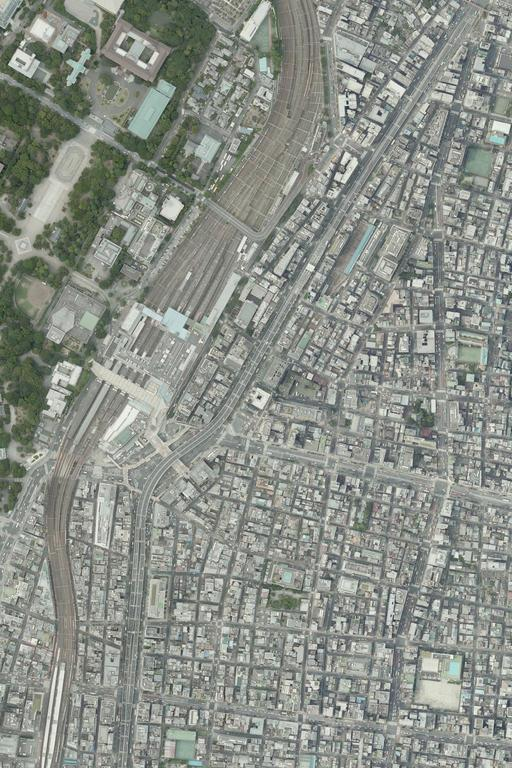

In [6]:
img_ueno = get_img_by_query("上野駅")
display(img_ueno)

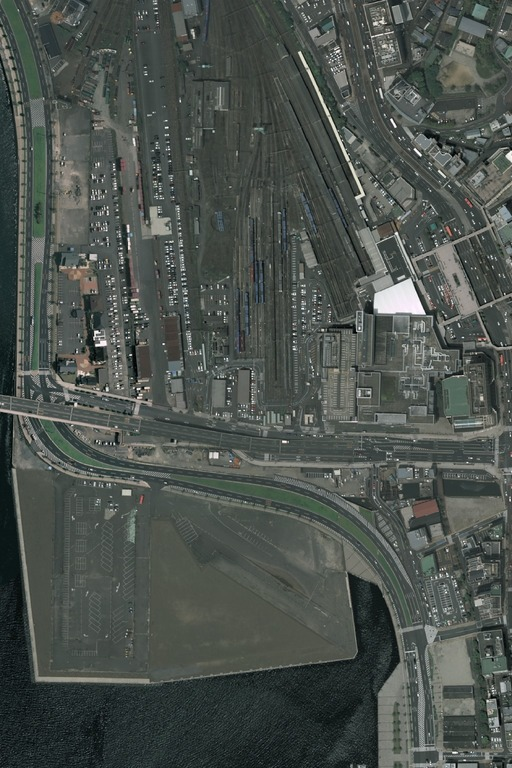

In [7]:
img_nagasaki = get_img_by_query("長崎駅")
display(img_nagasaki)

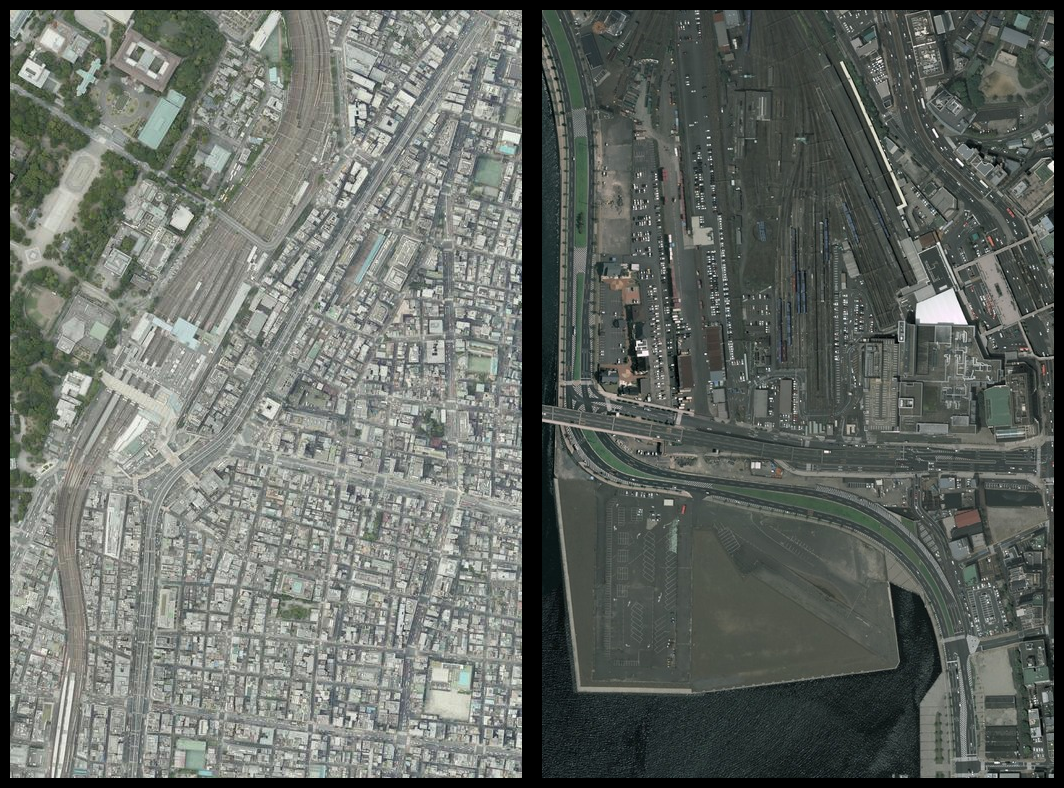

In [8]:
# img_ueno と img_nagasaki を横に並べて表示
from PIL import ImageOps

img_ueno = ImageOps.expand(img_ueno, border=10, fill="black")
img_nagasaki = ImageOps.expand(img_nagasaki, border=10, fill="black")

img_concat = Image.new("RGB", (img_ueno.width + img_nagasaki.width, max(img_ueno.height, img_nagasaki.height)))
img_concat.paste(img_ueno, (0, 0))
img_concat.paste(img_nagasaki, (img_ueno.width, 0))
display(img_concat)

In [9]:
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from io import BytesIO

import base64

# モデルの準備
model = ChatGoogleGenerativeAI(model="gemini-exp-1206", temperature=0)

# プロンプトの準備
text_prompt = """
一つ目は上野駅の画像です。
二つ目は長崎駅の画像です。
どちらがビルが多いですか？
"""
image_template_1 = {"image_url": {"url": "data:image/jpeg;base64,{img_b64_1}"}}
image_template_2 = {"image_url": {"url": "data:image/jpeg;base64,{img_b64_2}"}}

human_message_template = HumanMessagePromptTemplate.from_template([text_prompt, image_template_1, image_template_2])
prompt = ChatPromptTemplate.from_messages([human_message_template])

chain = prompt | model

buffer1 = BytesIO()
img_ueno.save(buffer1, format="JPEG")
img_ueno_b64 = base64.b64encode(buffer1.getvalue()).decode()

buffer2 = BytesIO()
img_nagasaki.save(buffer2, format="JPEG")
img_nagasaki_b64 = base64.b64encode(buffer2.getvalue()).decode()

res = chain.invoke({
    "img_b64_1": img_ueno_b64,
    "img_b64_2": img_nagasaki_b64
})
result = res.content.strip()
print(result)

提供された画像から判断すると、上野駅周辺の方が長崎駅周辺よりもビルが多いです。

* **上野駅周辺（1枚目の画像）:** 建物が密集しており、高層ビルと思われる影も多く見られます。道路も碁盤の目のように整備されており、都市化が進んでいる様子が伺えます。
* **長崎駅周辺（2枚目の画像）:** 駅の施設や線路が広い面積を占めており、建物は比較的まばらです。海に面していることもあり、上野駅周辺に比べると建物の密集度は低いです。

よって、上野駅周辺の方がビルが多いと判断できます。
